In [43]:
# Cargar librerias

import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import time
import multiprocessing
from multiprocessing import Value, Lock, Array, Lock, Process, cpu_count    # Paralelizacion

In [66]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [67]:
# Imprimir cuántos cores tiene la computadora

cores = cpu_count()
cpu = multiprocessing.cpu_count()

print('Cores en la computadora:', cores)
print("El numero de CPU trabajando actualmente en tu sistema : ", cpu)  
print("El numero de GPUs: ", len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

Cores en la computadora: 2
El numero de CPU trabajando actualmente en tu sistema :  2
El numero de GPUs:  1 Physical GPU, 2 Logical GPUs


In [68]:
# Se carga en dataset

df = pd.read_csv("mtto.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [69]:
# Se eliminan variables que no son importantes para el entrenamiento

df = df.drop(["UDI", "Product ID"], axis = 1)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


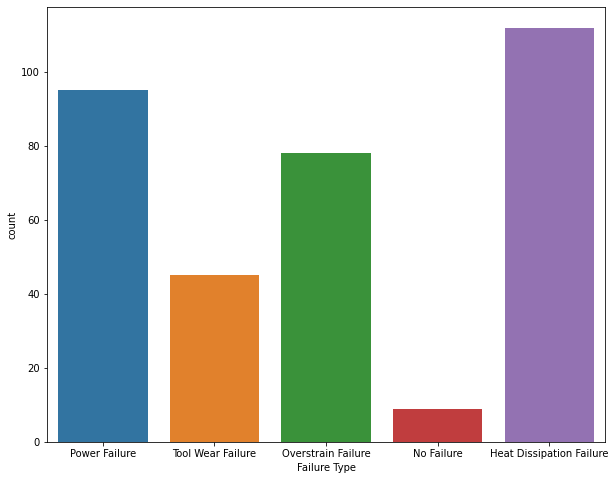

In [70]:
# Se grafica las fallas que se presentaron en el dataset

plt.figure(figsize = (10, 8))
sns.countplot(data = df[df['Target'] == 1], x = "Failure Type")

In [71]:
# Se categorizan los datos

df['Type'] = pd.Categorical(df['Type']).codes
df['Categorical Fail'] = pd.Categorical(df['Failure Type']).codes
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Categorical Fail
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
2,1,298.1,308.5,1498,49.4,5,0,No Failure,1
3,1,298.2,308.6,1433,39.5,7,0,No Failure,1
4,1,298.2,308.7,1408,40.0,9,0,No Failure,1


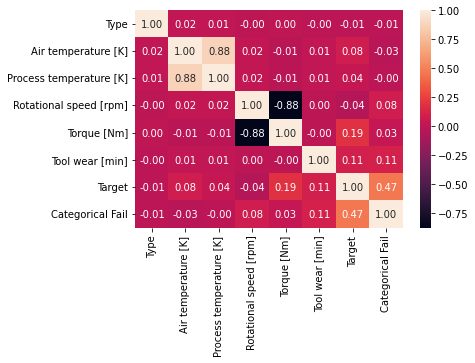

In [72]:
# Correlacion entre las variables

sns.heatmap(df.corr(), annot = True, fmt = ".2f")

In [73]:
# Se crean las variables "X" y "Y"

X=df[['Type',
      'Air temperature [K]',
      'Process temperature [K]', 
      'Rotational speed [rpm]', 
      'Torque [Nm]',
      'Tool wear [min]',
      'Target']]
y=df['Categorical Fail']

In [74]:
# Se normalizan los datos

for i in X.columns:
    X[i]=round((X[i]-X[i].min())/(X[i].max()-X[i].min()),3)
X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1.0,0.304,0.358,0.223,0.536,0.000,0.0
1,0.5,0.315,0.370,0.140,0.584,0.012,0.0
2,0.5,0.304,0.346,0.192,0.626,0.020,0.0
3,0.5,0.315,0.358,0.154,0.490,0.028,0.0
4,0.5,0.315,0.370,0.140,0.497,0.036,0.0


In [75]:
# Lectura de los datos

entrada = X.iloc[:].values 
respuesta = y.iloc[:].values

print("\nEntrada:\n", entrada[:5])
print("\nSalida:\n", respuesta[:5])


Entrada:
 [[1.    0.304 0.358 0.223 0.536 0.    0.   ]
 [0.5   0.315 0.37  0.14  0.584 0.012 0.   ]
 [0.5   0.304 0.346 0.192 0.626 0.02  0.   ]
 [0.5   0.315 0.358 0.154 0.49  0.028 0.   ]
 [0.5   0.315 0.37  0.14  0.497 0.036 0.   ]]

Salida:
 [1 1 1 1 1]


In [55]:
# Funcion para crear red Neuronal corrida en secuencial

start_time = time.perf_counter()

oculta1 = tf.keras.layers.Dense(units=64, activation='relu')
oculta2 = tf.keras.layers.Dense(units=32, activation='relu')

salida =  tf.keras.layers.Dense(units=1)
modelo =  tf.keras.Sequential([oculta1, oculta2, salida])

modelo.compile(loss='mse', 
               optimizer='sgd',
               metrics  =['accuracy']
)

historia = modelo.fit(entrada, respuesta, 
                      epochs=300,
                      verbose=False,
                      validation_split=.2)

finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")

Program finished in 170.52200200400011 seconds


In [91]:
# Crear red Neuronal en paralelo usando distribute.OneDeviceStrategy()
start_time = time.perf_counter()

tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.OneDeviceStrategy(device='/GPU:0')
#strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    oculta1 = tf.keras.layers.Dense(units=64, activation='relu')
    oculta2 = tf.keras.layers.Dense(units=32, activation='relu')

    salida =  tf.keras.layers.Dense(units=1)
    modelo =  tf.keras.Sequential([oculta1, oculta2, salida])

    modelo.compile(loss='mse', 
                   optimizer='sgd',
                   metrics  =['accuracy']
    )


historia = modelo.fit(entrada, respuesta, 
                      epochs=300,
                      verbose=False,
                      validation_split=.2)

finish_time = time.perf_counter()
print(f"Program finished in {finish_time-start_time} seconds")

Program finished in 19.403324345999863 seconds


In [88]:
history_dict = historia.history
dictkeys=list(history_dict.keys())
dictkeys

['loss', 'accuracy', 'val_loss', 'val_accuracy']

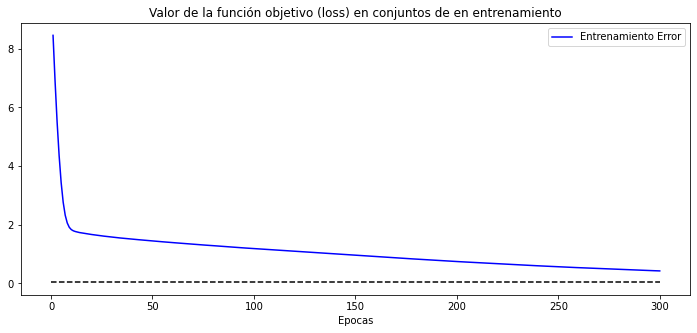

In [89]:
loss_values     = history_dict['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Entrenamiento Error')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento')
plt.xlabel('Epocas')
plt.ylabel('')
plt.hlines(y=.035, xmin=0, xmax=len(epochs), colors='k', linestyles='dashed')
plt.legend()

plt.show()

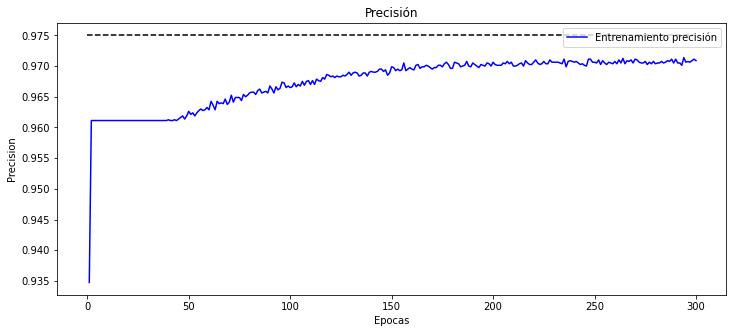

In [79]:
acc_values = history_dict['accuracy']

plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Entrenamiento precisión')
plt.title('Precisión')
plt.xlabel('Epocas')
plt.ylabel('Precision')
plt.hlines(y=.975, xmin=0, xmax=len(epochs), colors='k', linestyles='dashed')
plt.legend()

plt.show()

In [80]:
# Analizando los datos de salida

tipoFallo=df["Failure Type"].unique()
print(tipoFallo)

['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [81]:
prediccion=pd.DataFrame()
for x in tipoFallo:
  failure=df[df['Failure Type']==x]
  prediccion=prediccion.append(failure[:2])

In [82]:
prediccion.sort_values('Categorical Fail')

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Categorical Fail
3236,2,300.8,309.4,1342,62.4,113,1,Heat Dissipation Failure,0
3760,1,302.3,310.9,1377,46.8,166,1,Heat Dissipation Failure,0
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
160,1,298.4,308.2,1282,60.7,216,1,Overstrain Failure,2
161,1,298.3,308.1,1412,52.3,218,1,Overstrain Failure,2
50,1,298.9,309.1,2861,4.6,143,1,Power Failure,3
69,1,298.9,309.0,1410,65.7,191,1,Power Failure,3
1221,2,297.0,308.3,1399,46.4,132,0,Random Failures,4
1302,1,298.6,309.8,1505,45.7,144,0,Random Failures,4


In [83]:
# Se crean las variables "X_predic" y "Y_predic"

X_predic=prediccion[['Type',
      'Air temperature [K]',
      'Process temperature [K]', 
      'Rotational speed [rpm]', 
      'Torque [Nm]',
      'Tool wear [min]',
      'Target']]
y_predic=prediccion['Categorical Fail']

In [84]:
# Se normalizan los datos

for i in X_predic.columns:
    X_predic[i]=round((X_predic[i]-X_predic[i].min())/(X_predic[i].max()-X_predic[i].min()),3)
X_predic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,1.0,0.222,0.258,0.170,0.625,0.000,0.0
1,0.5,0.241,0.290,0.080,0.682,0.014,0.0
50,0.5,0.370,0.419,1.000,0.000,0.656,1.0
69,0.5,0.370,0.387,0.081,1.000,0.876,1.0
77,0.5,0.352,0.355,0.110,0.601,0.954,1.0
1087,0.0,0.000,0.000,0.169,0.511,0.945,1.0
160,0.5,0.278,0.129,0.000,0.918,0.991,1.0
161,0.5,0.259,0.097,0.082,0.781,1.000,1.0
1221,1.0,0.019,0.161,0.074,0.684,0.606,0.0
1302,0.5,0.315,0.645,0.141,0.673,0.661,0.0


In [85]:
# Lectura de los datos

entrada = X_predic.iloc[:].values 
respuesta = y_predic.iloc[:].values

print("\nEntrada:\n", entrada)
print("\nSalida:\n", respuesta)


Entrada:
 [[1.    0.222 0.258 0.17  0.625 0.    0.   ]
 [0.5   0.241 0.29  0.08  0.682 0.014 0.   ]
 [0.5   0.37  0.419 1.    0.    0.656 1.   ]
 [0.5   0.37  0.387 0.081 1.    0.876 1.   ]
 [0.5   0.352 0.355 0.11  0.601 0.954 1.   ]
 [0.    0.    0.    0.169 0.511 0.945 1.   ]
 [0.5   0.278 0.129 0.    0.918 0.991 1.   ]
 [0.5   0.259 0.097 0.082 0.781 1.    1.   ]
 [1.    0.019 0.161 0.074 0.684 0.606 0.   ]
 [0.5   0.315 0.645 0.141 0.673 0.661 0.   ]
 [1.    0.722 0.516 0.038 0.946 0.518 1.   ]
 [0.5   1.    1.    0.06  0.691 0.761 1.   ]]

Salida:
 [1 1 3 3 5 5 2 2 4 4 0 0]


In [86]:
# calcula las predicciones
predictions = modelo.predict(X_predic)
# redondeamos las predicciones
rounded = [round(x[0]) for x in predictions]
rounded

1/1 [==============================] - 0s 128ms/step


[1, 1, 3, 3, 4, 5, 2, 2, 1, 1, 1, 1]